In [2]:
!pip install keras==2.1.5

     |████████████████████████████████| 337kB 14.9MB/s 
ERROR: fancyimpute 0.4.3 requires tensorflow, which is not installed.
  Found existing installation: Keras 2.1.0
    Uninstalling Keras-2.1.0:
      Successfully uninstalled Keras-2.1.0


In [4]:
!pip install tensorflow-gpu==1.15.0

     |████████████████████████████████| 411.5MB 41kB/s 
     |████████████████████████████████| 3.8MB 52.5MB/s 
     |████████████████████████████████| 512kB 43.3MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=33b3047bf95d2b9b0d7313cf48213d8be65b616f6592890f5ecf8659e4354ad4
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.10.0rc0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 1.14.0
    Uninstalling tensorboard-1.14.0:
      Successfully uninstalled tensorboard-1.14.0
  Found existing installation: tensorflow-estimator 1.14.0
    Uninstalling tensorflow-estimator-1.14.0:
      Successfully uninstalled tensorflow-estimator-1.14.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing insta

# Training cGANs with MNIST dataset, Keras and Tensorflow

- Data
    - Rescale the MNIST images to be between -1 and 1.
- Generator
    - Simple fully connected neural network. LeakyRelu activation and BatchNormalization.
    - The input to the generator are the normal distribution z and y. They are combined in joint hidden representation.
        - Embedding(y, z)
    - The last activation is tanh.
- Discriminator
    - Simple fully connected neural network and LeakyRelu activation.
    - The input to the discriminator are x and y. They are combined in joint hidden representation.
        - Embedding (y, x)
    - The last activation is sigmoid.
- Loss
    - Binary_crossentropy
- Optimizer
    - Adam
- batch_size = 64
- epochs = 100


# 1. Load Data

### load libraries

In [0]:
import numpy as np

% matplotlib inline
import matplotlib.pyplot as plt

In [4]:
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, LeakyReLU, BatchNormalization
from keras.layers import Input, Flatten, Embedding, multiply, Dropout
from keras.optimizers import Adam
from keras import initializers

Using TensorFlow backend.


### Embedding layer background











[[[ 1.8745270e-02 -2.9630268e-02]
  [ 4.0792320e-02 -4.3994974e-02]
  [-1.0818981e-02  4.2148892e-02]
  [ 2.0327177e-02  2.1144141e-02]
  [-2.4907125e-02  4.4060957e-02]
  [-5.2296743e-03 -2.8616060e-02]
  [ 1.0243427e-02 -4.3012276e-03]
  [-1.2139142e-02  1.5836384e-02]
  [ 3.1393435e-02  3.5141949e-02]
  [-7.8717247e-03 -7.5984746e-05]]]


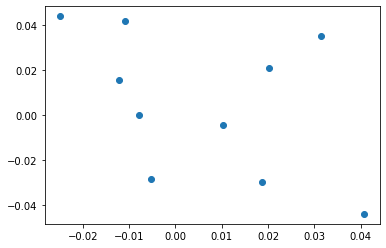

In [5]:
model = Sequential()
model.add(Embedding(10, 2))
# the model will take as input an integer matrix of size (batch, input_length).
# the largest integer (i.e. word index) in the input should be no larger than 999 (vocabulary size).
# now model.output_shape == (None, 10, 64), where None is the batch dimension.

# input_array = np.random.randint(10, size=(1, 10))
input_array = np.arange(0, 10).reshape(1, -1)
model.compile('rmsprop', 'mse')
output_array = model.predict(input_array)
print(output_array)
# print(output_array.shape)
plt.scatter(output_array[0, :, 0], output_array[0, :, 1])

### Getting the data

In [6]:
# load dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 1s 0us/step


### Explore visual data

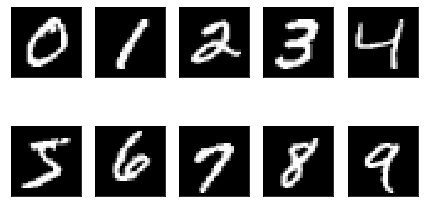

In [9]:
fig = plt.figure()
for i in range(10):
    plt.subplot(2, 5, i + 1)
    x_y = x_train[y_train == i]
    plt.imshow(x_y[0], cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()

### Reshaping and normalizing the inputs

In [11]:
print('X_train.shape', x_train.shape)
print('y_train.shape', y_train.shape)

# reshaping the inputs
x_train = x_train.reshape(60000, 28*28)
# normalizing the inputs (-1, 1)
x_train = (x_train.astype('float32') / 255 - 0.5) * 2

print('X_train reshape:', x_train.shape)

X_train.shape (60000, 28, 28)
y_train.shape (60000,)
X_train reshape: (60000, 784)


## Define model

### Generator

In [12]:
# latent space dimension
latent_dim = 100

# imagem dimension 28x28
img_dim = 784

init = initializers.RandomNormal(stddev=0.02)

# Generator network
generator = Sequential()

# Input layer and hidden layer 1
generator.add(Dense(128, input_shape=(latent_dim,), kernel_initializer=init))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))

# Hidden layer 2
generator.add(Dense(256))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))

# Hidden layer 3
generator.add(Dense(512))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))

# Output layer 
generator.add(Dense(img_dim, activation='tanh'))

generator.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               12928     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dense_3 (Dense)              (None, 512)               131584    
________

### Conditional G model
The prior input noise P(z) and y are combined in joint hidden representation.

In [13]:
# Embedding condition in input layer
num_classes = 10

# Create label embeddings
label = Input(shape=(1,), dtype='int32')
label_embedding = Embedding(num_classes, latent_dim)(label)
label_embedding = Flatten()(label_embedding)

# latent space
z = Input(shape=(latent_dim,))

# Merge inputs (z x label)
input_generator = multiply([z, label_embedding])

# Output image
img = generator(input_generator)

# Generator with condition input
generator = Model([z, label], img)

generator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 100)       1000        input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 100)          0           embedding_2[0][0]                
__________________________________________________________________________________________________
multiply_1

### Descriminator

In [14]:
# Discriminator network
discriminator = Sequential()

# Input layer and hidden layer 1
discriminator.add(Dense(128, input_shape=(img_dim,), kernel_initializer=init))
discriminator.add(LeakyReLU(alpha=0.2))

# Hidden layer 2
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(alpha=0.2))

# Hidden layer 3
discriminator.add(Dense(512))
discriminator.add(LeakyReLU(alpha=0.2))

# Output layer
discriminator.add(Dense(1, activation='sigmoid'))

discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               100480    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               33024     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 513       
Total para

### Conditional D model
x and y are presented as inputs

In [0]:
# Embedding condition in input layer

# Create label embeddings
label_d = Input(shape=(1,), dtype='int32')
label_embedding_d = Embedding(num_classes, img_dim)(label_d)
label_embedding_d = Flatten()(label_embedding_d)

# imagem dimension 28x28
img_d = Input(shape=(img_dim,))

# Merge inputs (img x label)
input_discriminator = multiply([img_d, label_embedding_d])

# Output image
validity = discriminator(input_discriminator)

# Discriminator with condition input
discriminator = Model([img_d, label_d], validity)

In [16]:
discriminator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 784)       7840        input_3[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 784)          0           embedding_3[0][0]                
__________________________________________________________________________________________________
multiply_2

## Compile model
### Compile discriminator

In [17]:
# Compile discriminator
optimizer = Adam(lr=0.0002, beta_1=0.5)

discriminator.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Combined network

In [0]:
discriminator.trainable = False

validity = discriminator([generator([z, label]), label])

d_g = Model([z, label], validity)

d_g.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])

In [19]:
# prints a summary representation of your model
d_g.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 784)          584312      input_2[0][0]                    
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
model_2 (Model)                 (None, 1)            273441      model_1[1][0]                    
          

## 4. Fit model

epoch = 1/100, d_loss=0.691, g_loss=0.864                                                                                                     


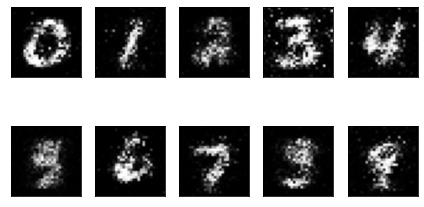

epoch = 2/100, d_loss=0.678, g_loss=0.819                                                                                                     
epoch = 3/100, d_loss=0.684, g_loss=0.810                                                                                                     
epoch = 4/100, d_loss=0.685, g_loss=0.806                                                                                                     
epoch = 5/100, d_loss=0.676, g_loss=0.808                                                                                                     
epoch = 6/100, d_loss=0.676, g_loss=0.804                                                                                                     
epoch = 7/100, d_loss=0.676, g_loss=0.802                                                                                                     
epoch = 8/100, d_loss=0.689, g_loss=0.834                                                                                                     

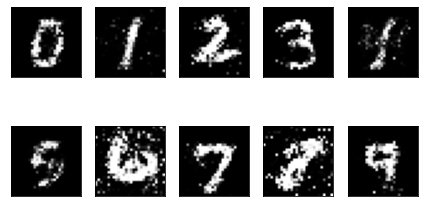

epoch = 12/100, d_loss=0.680, g_loss=0.818                                                                                                     
epoch = 13/100, d_loss=0.673, g_loss=0.816                                                                                                     
epoch = 14/100, d_loss=0.668, g_loss=0.815                                                                                                     
epoch = 15/100, d_loss=0.688, g_loss=0.823                                                                                                     
epoch = 16/100, d_loss=0.641, g_loss=0.844                                                                                                     
epoch = 17/100, d_loss=0.683, g_loss=0.845                                                                                                     
epoch = 18/100, d_loss=0.681, g_loss=0.833                                                                                              

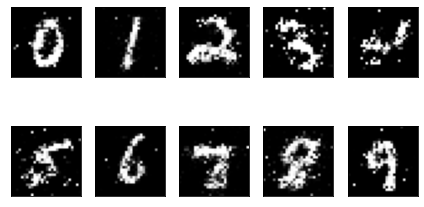

epoch = 22/100, d_loss=0.664, g_loss=0.810                                                                                                     
epoch = 23/100, d_loss=0.656, g_loss=0.856                                                                                                     
epoch = 24/100, d_loss=0.665, g_loss=0.831                                                                                                     
epoch = 25/100, d_loss=0.673, g_loss=0.831                                                                                                     
epoch = 26/100, d_loss=0.697, g_loss=0.843                                                                                                     
epoch = 27/100, d_loss=0.667, g_loss=0.830                                                                                                     
epoch = 28/100, d_loss=0.663, g_loss=0.877                                                                                              

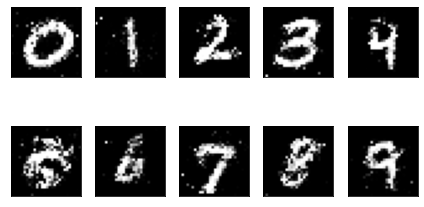

epoch = 32/100, d_loss=0.685, g_loss=0.861                                                                                                     
epoch = 33/100, d_loss=0.666, g_loss=0.856                                                                                                     
epoch = 34/100, d_loss=0.691, g_loss=0.857                                                                                                     
epoch = 35/100, d_loss=0.672, g_loss=0.810                                                                                                     
epoch = 36/100, d_loss=0.666, g_loss=0.879                                                                                                     
epoch = 37/100, d_loss=0.681, g_loss=0.860                                                                                                     
epoch = 38/100, d_loss=0.660, g_loss=0.909                                                                                              

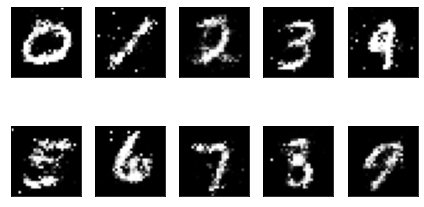

epoch = 42/100, d_loss=0.673, g_loss=0.867                                                                                                     
epoch = 43/100, d_loss=0.682, g_loss=0.885                                                                                                     
epoch = 44/100, d_loss=0.696, g_loss=0.873                                                                                                     
epoch = 45/100, d_loss=0.675, g_loss=0.863                                                                                                     
epoch = 46/100, d_loss=0.661, g_loss=0.825                                                                                                     
epoch = 47/100, d_loss=0.688, g_loss=0.845                                                                                                     
epoch = 48/100, d_loss=0.686, g_loss=0.840                                                                                              

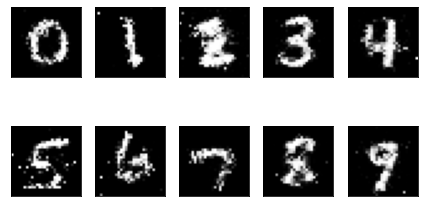

epoch = 52/100, d_loss=0.697, g_loss=0.842                                                                                                     
epoch = 53/100, d_loss=0.676, g_loss=0.869                                                                                                     
epoch = 54/100, d_loss=0.656, g_loss=0.892                                                                                                     
epoch = 55/100, d_loss=0.658, g_loss=0.897                                                                                                     
epoch = 56/100, d_loss=0.637, g_loss=0.874                                                                                                     
epoch = 57/100, d_loss=0.656, g_loss=0.893                                                                                                     
epoch = 58/100, d_loss=0.656, g_loss=0.845                                                                                              

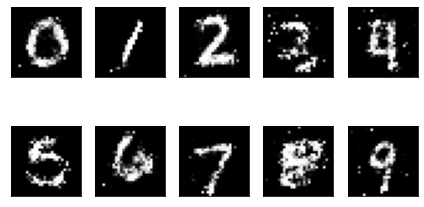

epoch = 62/100, d_loss=0.664, g_loss=0.903                                                                                                     
epoch = 63/100, d_loss=0.661, g_loss=0.886                                                                                                     
epoch = 64/100, d_loss=0.674, g_loss=0.899                                                                                                     
epoch = 65/100, d_loss=0.674, g_loss=0.873                                                                                                     
epoch = 66/100, d_loss=0.689, g_loss=0.843                                                                                                     
epoch = 67/100, d_loss=0.666, g_loss=0.852                                                                                                     
epoch = 68/100, d_loss=0.650, g_loss=0.889                                                                                              

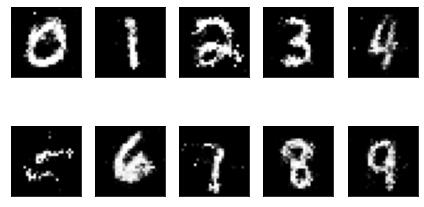

epoch = 72/100, d_loss=0.646, g_loss=0.827                                                                                                     
epoch = 73/100, d_loss=0.667, g_loss=0.907                                                                                                     
epoch = 74/100, d_loss=0.662, g_loss=0.864                                                                                                     
epoch = 75/100, d_loss=0.689, g_loss=0.869                                                                                                     
epoch = 76/100, d_loss=0.681, g_loss=0.869                                                                                                     
epoch = 77/100, d_loss=0.651, g_loss=0.883                                                                                                     
epoch = 78/100, d_loss=0.672, g_loss=0.919                                                                                              

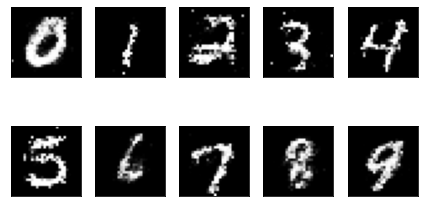

epoch = 82/100, d_loss=0.681, g_loss=0.888                                                                                                     
epoch = 83/100, d_loss=0.668, g_loss=0.886                                                                                                     
epoch = 84/100, d_loss=0.669, g_loss=0.876                                                                                                     
epoch = 85/100, d_loss=0.652, g_loss=0.892                                                                                                     
epoch = 86/100, d_loss=0.681, g_loss=0.873                                                                                                     
epoch = 87/100, d_loss=0.676, g_loss=0.843                                                                                                     
epoch = 88/100, d_loss=0.660, g_loss=0.834                                                                                              

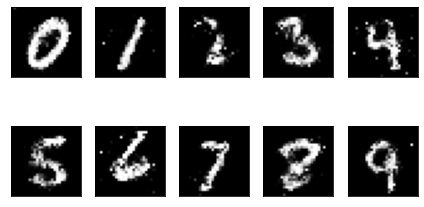

epoch = 92/100, d_loss=0.666, g_loss=0.822                                                                                                     
epoch = 93/100, d_loss=0.692, g_loss=0.878                                                                                                     
epoch = 94/100, d_loss=0.664, g_loss=0.907                                                                                                     
epoch = 95/100, d_loss=0.633, g_loss=0.861                                                                                                     
epoch = 96/100, d_loss=0.685, g_loss=0.841                                                                                                     
epoch = 97/100, d_loss=0.649, g_loss=0.923                                                                                                     
epoch = 98/100, d_loss=0.628, g_loss=0.893                                                                                              

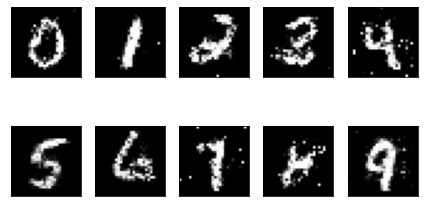

In [22]:
epochs = 100
batch_size = 64
smooth = 0.1

real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))

d_loss = []
d_g_loss = []

for e in range(epochs + 1):
    for i in range(len(x_train) // batch_size):
        
        # Train Discriminator weights
        discriminator.trainable = True
        
        # Real samples
        X_batch = x_train[i*batch_size:(i+1)*batch_size]
        real_labels = y_train[i*batch_size:(i+1)*batch_size].reshape(-1, 1)
        
        d_loss_real = discriminator.train_on_batch(x=[X_batch, real_labels], y=real * (1 - smooth))
        
        # Fake Samples
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        random_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)
        X_fake = generator.predict_on_batch([z, random_labels])
        
        d_loss_fake = discriminator.train_on_batch(x=[X_fake, random_labels], y=fake)
         
        # Discriminator loss
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])
        
        # Train Generator weights
        discriminator.trainable = False
        
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        random_labels = np.random.randint(0, 10, batch_size).reshape(-1, 1)
        d_g_loss_batch = d_g.train_on_batch(x=[z, random_labels], y=real)
   
        print(
            'epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, i, len(x_train) // batch_size, d_loss_batch, d_g_loss_batch[0]),
            100*' ',
            end='\r'
        )
    
    d_loss.append(d_loss_batch)
    d_g_loss.append(d_g_loss_batch[0])
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], d_g_loss[-1]), 100*' ')

    if e % 10 == 0:
        samples = 10
        z = np.random.normal(loc=0, scale=1, size=(samples, latent_dim))
        labels = np.arange(0, 10).reshape(-1, 1)
        
        x_fake = generator.predict([z, labels])

        for k in range(samples):
            plt.subplot(2, 5, k+1)
            plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
            plt.xticks([])
            plt.yticks([])

        plt.tight_layout()
        plt.show()

## evaluate model

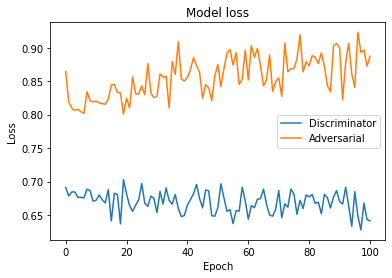

In [23]:
# plotting the metrics
plt.plot(d_loss)
plt.plot(d_g_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()

## Reference
https://github.com/mafda/generative_adversarial_networks_101/blob/master/src/mnist/01_GAN_MNIST.ipynb